In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###These files are from the [assign taxonomy notebook](./Assign_taxonomy.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [3]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 466 samples ]
sample_data() Sample Data:       [ 466 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 10361 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]


### Get log2foldchange for CC

In [4]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C000",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [5]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C000"))

registerDoParallel(20)

df.l2fc.CC = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [6]:
%%R
df.l2fc.CC = df.l2fc.CC %.%
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.CC

Source: local data frame [136,807 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C000 OTU.11642    -0.90172182 0.8588611 Bacteria
2                0.05  14    13C000 OTU.12643    -0.39624914 0.7727994 Bacteria
3                0.05  14    13C000 OTU.12562     0.77933903 0.4923539 Bacteria
4                0.05  14    13C000  OTU.4204    -0.20544785 0.9999991 Bacteria
5                0.05  14    13C000   OTU.467    -0.33034377 0.9999959 Bacteria
6                0.05  14    13C000   OTU.905     0.01698161 0.9409344 Bacteria
7                0.05  14    13C000  OTU.7253     0.02615064 0.9305930 Bacteria
8                0.05  14    13C000    OTU.67    -0.60130140 1.0000000 Bacteria
9                0.05  14    13C000 OTU.10580     0.35997190 0.6272233 Bacteria
10               0.05  14    13C000  OTU.4907     0.17895387 0.9999994 Bacteria
..                ... ...       ... 

### Get log2foldchange for 100

In [7]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C100",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [8]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C100"))

registerDoParallel(20)

df.l2fc.100 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [9]:
%%R
df.l2fc.100 = df.l2fc.100 %.% 
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.100

Source: local data frame [123,320 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange          p
1                0.05  14    13C100 OTU.11642     1.86640621 0.21228907
2                0.05  14    13C100  OTU.4204    -0.12055084 0.99990303
3                0.05  14    13C100   OTU.467     0.55860664 0.65637280
4                0.05  14    13C100   OTU.905     0.20651232 0.73221266
5                0.05  14    13C100  OTU.7253     2.17512546 0.03440459
6                0.05  14    13C100    OTU.67     0.03413556 0.98168844
7                0.05  14    13C100 OTU.10580     3.21495409 0.03394705
8                0.05  14    13C100  OTU.4907     0.06688307 0.99999973
9                0.05  14    13C100  OTU.7898     0.32740807 0.98243768
10               0.05  14    13C100  OTU.8632     0.08524245 0.68377200
..                ... ...       ...       ...            ...        ...
Variables not shown: Rank1 (fctr), Rank2 (fctr), Ran

### Get log2foldchange for 700

In [10]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C700",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [11]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C700"))

registerDoParallel(20)

df.l2fc.700 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [12]:
%%R
df.l2fc.700 = df.l2fc.700 %.% 
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.700

Source: local data frame [137,309 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange          p
1                0.05  14    13C700  OTU.4204      0.2951127 0.87289454
2                0.05  14    13C700   OTU.467      1.1748995 0.17315591
3                0.05  14    13C700   OTU.905     -0.2726527 0.92806436
4                0.05  14    13C700  OTU.7253      1.7721812 0.08577159
5                0.05  14    13C700    OTU.67     -0.3273769 0.99873581
6                0.05  14    13C700 OTU.10580      1.0737168 0.40943299
7                0.05  14    13C700  OTU.4907      0.6242936 0.61582105
8                0.05  14    13C700  OTU.7898      0.4178486 0.77884399
9                0.05  14    13C700   OTU.125      0.3489531 0.83278401
10               0.05  14    13C700  OTU.3516      0.9217271 0.45411090
..                ... ...       ...       ...            ...        ...
Variables not shown: Rank1 (fctr), Rank2 (fctr), Ran

### Combine SS and PS dataframes then determine sparsity threshold

In [13]:
%%R
combined_l2fc = rbind(df.l2fc.CC, df.l2fc.100, df.l2fc.700)
combined_l2fc

Source: local data frame [397,436 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C000 OTU.11642    -0.90172182 0.8588611 Bacteria
2                0.05  14    13C000 OTU.12643    -0.39624914 0.7727994 Bacteria
3                0.05  14    13C000 OTU.12562     0.77933903 0.4923539 Bacteria
4                0.05  14    13C000  OTU.4204    -0.20544785 0.9999991 Bacteria
5                0.05  14    13C000   OTU.467    -0.33034377 0.9999959 Bacteria
6                0.05  14    13C000   OTU.905     0.01698161 0.9409344 Bacteria
7                0.05  14    13C000  OTU.7253     0.02615064 0.9305930 Bacteria
8                0.05  14    13C000    OTU.67    -0.60130140 1.0000000 Bacteria
9                0.05  14    13C000 OTU.10580     0.35997190 0.6272233 Bacteria
10               0.05  14    13C000  OTU.4907     0.17895387 0.9999994 Bacteria
..                ... ...       ... 

In [14]:
%%R
d = combined_l2fc %.% 
    group_by(sparsity_threshold) %.%
    summarize(sum_pass_FDR = sum(padj < 0.10))
d

Source: local data frame [19 x 2]

   sparsity_threshold sum_pass_FDR
1                0.05         1760
2                0.10         1894
3                0.15         1989
4                0.20         2027
5                0.25         2016
6                0.30         1958
7                0.35         1936
8                0.40         1837
9                0.45         1736
10               0.50         1673
11               0.55         1614
12               0.60         1533
13               0.65         1423
14               0.70         1353
15               0.75         1275
16               0.80         1164
17               0.85         1028
18               0.90          815
19               0.95          439


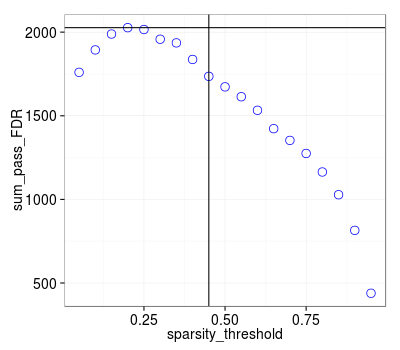

In [15]:
%%R -w 400 -h 350

p = ggplot(d, aes(x = sparsity_threshold, y = sum_pass_FDR))

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.45)

p = p + geom_hline(y = max(d$sum_pass_FDR))

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14))

p

### Make dataframe that will be used for log2 fold change figures

In [24]:
%%R
sparsity.threshold = 0.45

df.l2fc = combined_l2fc %>% 
    filter(sparsity_threshold >= sparsity.threshold) %>%
    group_by(Treatment) %>%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc

Source: local data frame [136,618 x 15]
Groups: Treatment

   sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1                0.45  14    13C000 OTU.4204    -0.20543977 0.9999991 Bacteria
2                0.45  14    13C000  OTU.467    -0.32975385 0.9999957 Bacteria
3                0.45  14    13C000  OTU.905     0.01693499 0.9444023 Bacteria
4                0.45  14    13C000 OTU.7253     0.02959686 0.9328765 Bacteria
5                0.45  14    13C000   OTU.67    -0.60063536 1.0000000 Bacteria
6                0.45  14    13C000 OTU.4907     0.17904571 0.9999992 Bacteria
7                0.45  14    13C000 OTU.7898     0.32207772 0.9870169 Bacteria
8                0.45  14    13C000  OTU.125    -0.15079026 1.0000000 Bacteria
9                0.45  14    13C000 OTU.3516    -0.17573786 0.8745698 Bacteria
10               0.45  14    13C000 OTU.9497     0.89584208 0.2531573 Bacteria
..                ... ...       ...      ...            ...       ...   

In [26]:
%%R

write.table(df.l2fc, 
            file = "/var/seq_data/priming_exp/data/l2fc_table.csv",
            row.names = FALSE,
            sep = ",")

In [27]:
!head /var/seq_data/priming_exp/data/l2fc_table.csv | cut -c1-100

"sparsity_threshold","Day","Treatment","OTU","log2FoldChange","p","Rank1","Rank2","Rank3","Rank4","R
0.45,14,"13C000","OTU.4204",-0.205439771058824,0.999999065640418,"Bacteria","Acidobacteria","DA023",
0.45,14,"13C000","OTU.467",-0.329753849298316,0.999995674772677,"Bacteria","Acidobacteria","DA023","
0.45,14,"13C000","OTU.905",0.0169349858903954,0.94440233938488,"Bacteria","Acidobacteria","DA023","u
0.45,14,"13C000","OTU.7253",0.0295968615610199,0.932876517678725,"Bacteria","Acidobacteria","DA023",
0.45,14,"13C000","OTU.67",-0.600635364661309,0.999999998578617,"Bacteria","Acidobacteria","DA023","u
0.45,14,"13C000","OTU.4907",0.179045710971328,0.999999186685025,"Bacteria","Acidobacteria","DA023","
0.45,14,"13C000","OTU.7898",0.322077724462856,0.987016947061489,"Bacteria","Acidobacteria","DA023","
0.45,14,"13C000","OTU.125",-0.150790263470163,0.999999998726782,"Bacteria","Acidobacteria","DA023","
0.45,14,"13C000","OTU.3516",-0.175737859304129,0.874569770872288,"Bacteria","Acidobacteria"